In [1]:
from notebook_util_minee import *
%matplotlib inline

In [2]:
from minee.data.mix_uniform import MixedUniform

## Data

In [3]:
np.random.seed(0)
mix = 0.5
width = 2

In [4]:
import ipywidgets as widgets

In [5]:
sample_size = 300
model = MixedUniform(n_samples=sample_size, mix=0.5, width_a=width, width_b=width)
data = model.data
groundtruth_mi = model.ground_truth
data_t = torch.Tensor(data)

Separate X data and Y data for the estimation. This should be a preprocessing done before instead of after feeding the data to the model.

In [6]:
X = data[:,[0]]
Y = data[:,[1]]

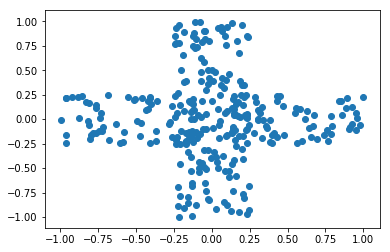

In [7]:
plt.scatter(X,Y)
plt.show()
plt.close()

Generate the reference samples by uniform sampling.

In [8]:
X_ref = uniform_sample(X.min(axis=0),X.max(axis=0),sample_size)
Y_ref = uniform_sample(Y.min(axis=0),Y.max(axis=0),sample_size)

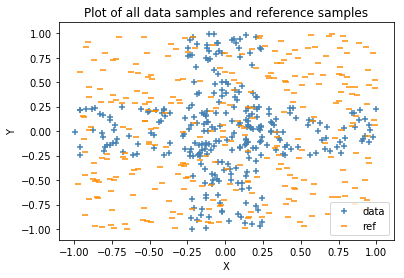

In [9]:
plt.scatter(X,Y,label="data",marker="+",color="steelblue")
plt.scatter(X_ref,Y_ref,label="ref",marker="_",color="darkorange")
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot of all data samples and reference samples')
plt.legend()
plt.show()
plt.close()

## MI estimation

### Choice of parameters

In [10]:
batch_size = int(sample_size*1)
lr = 1e-3
fnames = ['mix_uniform_minee_sams32.pt','mix_uniform_minee_sams64.pt','mix_uniform_minee_sams100.pt','mix_uniform_minee_sams200.pt','mix_uniform_minee_sams300.pt']

In [11]:
from ipywidgets import widgets
fns = widgets.Dropdown(options=fnames,description="Select a file:")
display(fns)

Dropdown(description='Select a file:', options=('mix_uniform_minee_sams32.pt', 'mix_uniform_minee_sams64.pt', …

### Initialization

In [12]:
fname = fns.value

In [13]:
XY_t = torch.Tensor(np.concatenate((X,Y),axis=1))
X_t = torch.Tensor(X)
Y_t = torch.Tensor(Y)

XY_ref_t = torch.Tensor(np.concatenate((X_ref,Y_ref),axis=1))
X_ref_t = torch.Tensor(X_ref)
Y_ref_t = torch.Tensor(Y_ref)

XY_net = Net(input_size=X.shape[1]+Y.shape[1],hidden_size=100)
X_net = Net(input_size=X.shape[1],hidden_size=100)
Y_net = Net(input_size=Y.shape[1],hidden_size=100)
XY_optimizer = optim.Adam(XY_net.parameters(),lr=lr)
X_optimizer = optim.Adam(X_net.parameters(),lr=lr)
Y_optimizer = optim.Adam(Y_net.parameters(),lr=lr)

# For storing the results

XY_net_list = []
X_net_list = []
Y_net_list = []

dXY_list = []
dX_list = []
dY_list = []

### Training
Automatically load previous results from db file if exists

In [14]:
if os.path.exists(fname):
    with open(fname,'rb') as f:
        checkpoint = torch.load(fname,map_location = "cuda" if torch.cuda.is_available() else "cpu")
        XY_net_list = checkpoint['XY_net_list']
        X_net_list = checkpoint['X_net_list']
        Y_net_list = checkpoint['Y_net_list']
        dXY_list = checkpoint['dXY_list']
        dX_list = checkpoint['dX_list']
        dY_list = checkpoint['dY_list']
        XY_net.load_state_dict(XY_net_list[-1])
        X_net.load_state_dict(X_net_list[-1])
        Y_net.load_state_dict(Y_net_list[-1])
        print('results loaded from '+fname)
else:
    for j in range(50):
        for i in range(200):
            XY_optimizer.zero_grad()
            X_optimizer.zero_grad()
            Y_optimizer.zero_grad()
            batch_XY = resample(XY_t,batch_size=batch_size)
            batch_X = resample(X_t, batch_size=batch_size)
            batch_Y = resample(Y_t,batch_size=batch_size)
            batch_XY_ref = torch.Tensor(np.concatenate((uniform_sample(X.min(axis=0),X.max(axis=0),batch_size), \
                                                        uniform_sample(Y.min(axis=0),Y.max(axis=0),batch_size)),axis=1))
            batch_X_ref = batch_XY_ref[:,0:X.shape[1]]
            batch_Y_ref = batch_XY_ref[:,-Y.shape[1]:]
            
            fXY = XY_net(batch_XY)
            efXY_ref = torch.exp(XY_net(batch_XY_ref))
            batch_dXY = torch.mean(fXY) - torch.log(torch.mean(efXY_ref))
            batch_loss_XY = -batch_dXY
            batch_loss_XY.backward()
            XY_optimizer.step()    
            dXY_list = np.append(dXY_list, \
                                    (torch.mean(XY_net(XY_t)) \
                                     - torch.log(torch.mean(torch.exp(XY_net(XY_ref_t))))).cpu().item())

            fX = X_net(batch_X)
            efX_ref = torch.exp(X_net(batch_X_ref))
            batch_dX = torch.mean(fX) - torch.log(torch.mean(efX_ref))
            batch_loss_X = -batch_dX
            batch_loss_X.backward()
            X_optimizer.step()    
            dX_list = np.append(dX_list, \
                                    (torch.mean(X_net(X_t)) \
                                     - torch.log(torch.mean(torch.exp(X_net(X_ref_t))))).cpu().item())
            
            fY = Y_net(batch_Y)
            efY_ref = torch.exp(Y_net(batch_Y_ref))
            batch_dY = torch.mean(fY) - torch.log(torch.mean(efY_ref))
            batch_loss_Y = -batch_dY
            batch_loss_Y.backward()
            Y_optimizer.step()    
            dY_list = np.append(dY_list, \
                                    (torch.mean(Y_net(Y_t)) \
                                     - torch.log(torch.mean(torch.exp(Y_net(Y_ref_t))))).cpu().item())            
            
        XY_net_list = np.append(XY_net_list,copy.deepcopy(XY_net.state_dict()))
        X_net_list = np.append(X_net_list,copy.deepcopy(X_net.state_dict()))
        Y_net_list = np.append(Y_net_list,copy.deepcopy(Y_net.state_dict()))

        # To save intermediate works, change the condition to True
        if False:
            with open(str(j)+fname,'wb') as f:
                dill.dump([XY_net_list,X_net_list,Y_net_list,dX_list,dXY_list,dY_list],f)
                print('results saved: '+str(j))

results loaded from mix_uniform_minee_sams200.pt


To save new results to a db file using the following code, delete the existing db file.

In [15]:
if not os.path.exists(fname):
    with open(fname,'wb') as f:
        torch.save({
            'dXY_list' : dXY_list,
            'dX_list' : dX_list,
            'dY_list' : dY_list,
            'XY_net_list' : XY_net_list,
            'X_net_list' : X_net_list,
            'Y_net_list' : Y_net_list
        },f)
        #dill.dump([XY_net_list,X_net_list,Y_net_list,dXY_list,dX_list,dY_list],f)
        print('results saved to '+fname)

## Analysis

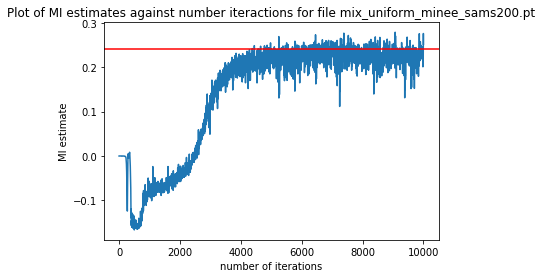

Red line denotes ground truth mutual information


In [16]:
mi_list = dXY_list-dX_list-dY_list
plt.plot(mi_list)
plt.axhline(groundtruth_mi, color="red")
plt.title("Plot of MI estimates against number iteractions for file %s" % (fname))
plt.xlabel("number of iterations")
plt.ylabel("MI estimate")
plt.show()
plt.close()
print("Red line denotes ground truth mutual information")

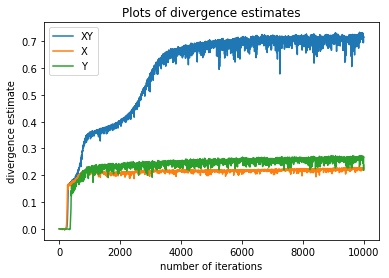

In [17]:
plt.plot(dXY_list,label="XY")
plt.plot(dX_list,label="X")
plt.plot(dY_list,label="Y")
plt.title("Plots of divergence estimates")
plt.xlabel("number of iterations")
plt.ylabel("divergence estimate")
plt.legend()
plt.show()
plt.close()

In [18]:
XY_net_ = copy.deepcopy(XY_net)
X_net_ = copy.deepcopy(X_net)
Y_net_ = copy.deepcopy(Y_net)

In [19]:
T = mi_list.size # total number of iteractions
dt = T // XY_net_list.shape[0] # period for each snapshot of the NN
@interact(t=(dt,T,dt))
def f(t=T):
    plt.subplot(221)
    plt.plot(mi_list)
    plt.axvline(t)
    plt.subplot(222)
    XY_net_.load_state_dict(XY_net_list[(t // dt) - 1])
    plot_net_2(XY_net_)
    plt.subplot(223)
    X_net_.load_state_dict(X_net_list[(t // dt) - 1])
    plot_net_1(X_net_)
    plt.subplot(224)
    Y_net_.load_state_dict(Y_net_list[(t // dt) - 1])
    plot_net_1(Y_net_)
    plt.plot()
    plt.show()
    plt.close()

interactive(children=(IntSlider(value=10000, description='t', max=10000, min=200, step=200), Output()), _dom_c…

In [20]:
@interact(t=(100,T,100))
def f(t=T):
    print("Ground truth MI is %s" % (groundtruth_mi))
    w = 50
    plt.plot(mi_list,color='orange')
    plt.axhline(groundtruth_mi, color="red")
    mi = mi_list[:t+1][-w:].mean()
    plt.axhline(mi)
    plt.axvline(t)
    print("Predicted MI for iteration %s is %s" % (t, mi))
    plt.close

interactive(children=(IntSlider(value=10000, description='t', max=10000, min=100, step=100), Output()), _dom_c…